###################  GALAXY GEM ###############################
######## Project Topic: Using Convolutional Neural Networks for Galaxy Morphology Classification ########
#######  Group Members:
#######  Tram Le – hle12@kent.edu
#######  Thi Minh Thu Nguyen – tnguye69@kent.edu
#######  Nickson Ibrahim Makama – nibrahi3@kent.edu
#######  Thanyaporn Noiplab – tnoiplab@kent.edu
###########################################################

In [ ]:
pip install astroNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 75.1 MB/s eta 0:00:00


In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 18.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import imp
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch, time
from tqdm import tqdm


from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy
import torch.optim as optim

import torchvision.models as models
from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

In [ ]:
# define device for Torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
images, labels = load_galaxy10()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to float
labels = labels.astype(np.float32)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [03:08<00:00, 14.8MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [03:16, 13.9MB/s]                            


In [ ]:
## Split the dataset 90/10

In [ ]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((15962, 256, 256, 3), (15962, 10), (1774, 256, 256, 3), (1774, 10))

### Build custom class to takes in images and labels and transform to be applied bc only to do augmentation of train set


In [ ]:
class Galaxy10(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img =  img.astype(np.uint8)
            img = Image.fromarray(img)        # Ensure img is PILLOW Image cuz currently it's a numpy array
            img = self.transform(img)

        return img, label

### Do augmentation and transform the images
- https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html


In [ ]:
# augmentation and convert to tensor for train
transform_train = transforms.Compose([
      transforms.TrivialAugmentWide(),
      # transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
      # transforms.ColorJitter(brightness=(0.9, 2), contrast=(0.8, 1.2)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.Resize(224),
      transforms.ToTensor(),         # Converts np (H x W x C) to torch (C x H x W)
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))       # and norm from 0-255 to 0-1
      ])

# only convert to tensor for train
transform_test = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

train_ds = Galaxy10(train_images, train_labels, transform=transform_train)
test_ds = Galaxy10(test_images, test_labels, transform=transform_test)

print(len(train_ds))
print(len(test_ds))

15962
1774


### Use DataLoader to helps to speed up computation and reduce RAM usage, handling loading and batching during training
- Use GradScaler to help scaling the loss value, control the gradients range, faster training on NVIDIA GPUs with mix precision with both float16 and float32 precisions.


In [ ]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn', force=True) # fix the fork issue in colab

train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)

# no shuffle on test loader
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=0,
                                         pin_memory=True)

# Checking the number of batches in each loader
print(f"Number batches in training: {len(train_loader)}")    # 14188 / 64  = 222 batch
print(f"Number batches in test: {len(test_loader)}")
for images, labels in train_loader:
    print(f"Shape of 1st batch training (after transformations): {images.shape}")
    print(f"Shape of the (labels): {labels.shape}")  # Should 128
    break

Number batches in training: 250
Number batches in test: 28
Shape of 1st batch training (after transformations): torch.Size([64, 3, 224, 224])
Shape of the (labels): torch.Size([64, 10])


### Build Model

- freeze the weights in the Conv layers (so they wont change during training) so that only train new set of layers at the end of the network.
- new layers will learn to make predict based on the feature maps from  
pre-trained.
- give a bad result from pretrain, so train model with random initilized weight from scatch

In [ ]:

base_model = models.resnet50(pretrained=False)
# # Freeze all the parameters in the feature extraction
# for param in base_model.parameters():
#     param.requires_grad = False


#=========== Tranfer learning 1
class RestNet(nn.Module):
    def __init__(self, original_model):
        super(RestNet, self).__init__()

        # Remove the last of resnet layer
        self.features = nn.Sequential(*list(original_model.children())[:-2])

        # Append more FC layers
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 10),  #FC 10 classes
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through the feature layers
        x = self.classifier(x)
        return x

model = RestNet(base_model)
model.to(device)

from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Determine:
- The metrics: accurary to cal the number of correctly predicted results / total number of samples
- Objective funtion for loss is crossentropy because this is classification problems
- Optimizer with Adam
- Add L2 regulation at 0.01

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"

In [ ]:
top1_acc = Accuracy(task="multiclass", num_classes=10).to(device)

#Mixed Precision training
scaler = torch.cuda.amp.GradScaler()

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)

print("Training with Adam")

Training with Adam


### Train process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the directory and the filename
directory_path = '/content/drive/My Drive/Model'
model_filename = "galaxy_r50_model.pth"
save_path = os.path.join(directory_path, model_filename)

import os
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print("Directory created:", directory_path)
else:
    print("Directory already exists.")

print("Saving model to:", save_path)


Mounted at /content/drive
Directory already exists.
Saving model to: /content/drive/My Drive/Model/galaxy_r50_model.pth


In [ ]:
top1 = []
train_time = []
test_time = []
train_acc = []
train_loss = []
val_acc = []
val_loss = []
counter = 0
epoch = 0

while counter < 15:   # Counter number of epochs of non-improvement before stopping

    # Training Phase
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    train_batch_count = 0
    start_train_time = time.time()

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1} Training") as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                acc = (outputs.argmax(dim=1) == labels.argmax(dim=1)).float().mean()

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Loss and accuracy tracking
            running_train_loss += loss.item()
            running_train_acc += acc.item()
            train_batch_count += 1

            tepoch.set_postfix_str(f"train loss: {running_train_loss / train_batch_count:.4f} - train acc: {running_train_acc / train_batch_count:.4f}")


    end_train_time = time.time()
    train_time.append(end_train_time - start_train_time)
    train_acc.append(running_train_acc / train_batch_count)
    train_loss.append(running_train_loss / train_batch_count)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    val_batch_count = 0
    val_y_true = []
    val_y_pred = []
    start_test_time = time.time()

    with torch.no_grad(), tqdm(test_loader, unit="batch", desc=f"Epoch {epoch+1} Validation") as vepoch:
        for images, labels in vepoch:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels.argmax(dim=1)).float().mean()

            # Update lists for classification report
            val_y_true.extend(labels.cpu().tolist())
            val_y_pred.extend(outputs.argmax(dim=1).cpu().tolist())

            # Loss and accuracy tracking
            running_val_loss += loss.item()
            running_val_acc += acc.item()
            val_batch_count += 1

            # Update progress bar postfix
            vepoch.set_postfix_str(f"val loss: {running_val_loss / val_batch_count:.4f} - val acc: {running_val_acc / val_batch_count:.4f}")



    end_test_time = time.time()
    test_time.append(end_test_time - start_test_time)
    val_acc.append(running_val_acc / val_batch_count)
    val_loss.append(running_val_loss / val_batch_count)

    current_val_acc = running_val_acc / val_batch_count
    top1.append(current_val_acc)

    # Early stopping condition
    if current_val_acc >= max(top1[:-1], default=0):
        torch.save(model.state_dict(), save_path)  # Replace with your model save path
        # print("Model improved and saved.")
        counter = 0
    else:
        counter += 1

    if counter >= 15:
        print("\nEarly stopping triggered.")
        break

    epoch += 1

Epoch 130 Validation: 100%|██████████| 28/28 [00:04<00:00,  6.97batch/s, val loss: 0.6379 - val acc: 0.8040]


Early stopping triggered.


In [ ]:
print('Finished Training')
print("Results")
print(f"Top 1 Accuracy: {max(top1):.2f} - Train Time: {min(train_time):.0f} -Test Time: {min(test_time):.0f}\n")

Finished Training
Results
Top 1 Accuracy: 0.81 - Train Time: 59 -Test Time: 4



In [ ]:
val_y_true = [np.argmax(y, axis=None) for y in val_y_true]


In [ ]:
from sklearn.metrics import accuracy_score

overall_accuracy = accuracy_score(val_y_true, val_y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


Overall Accuracy: 0.8044


In [ ]:
# Calculate and print classification report
print(classification_report(val_y_true, val_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.19      0.29       111
           1       0.83      0.86      0.85       179
           2       0.97      0.87      0.92       264
           3       0.83      0.94      0.88       213
           4       0.68      0.78      0.72        32
           5       0.96      0.75      0.84       203
           6       0.70      0.83      0.76       193
           7       0.62      0.76      0.68       251
           8       0.79      0.94      0.86       147
           9       0.91      0.86      0.88       181

    accuracy                           0.80      1774
   macro avg       0.79      0.78      0.77      1774
weighted avg       0.81      0.80      0.80      1774



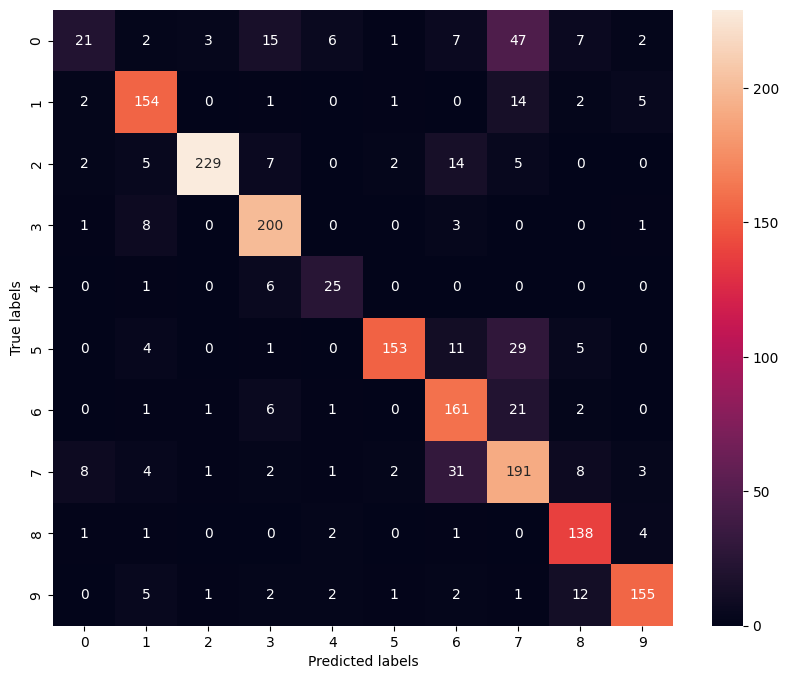

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(val_y_true, val_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()
fig.add_trace(graph.Scatter(y=train_acc, mode='lines', name='Training Accuracy'))
fig.add_trace(graph.Scatter(y=val_acc, mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show()

In [ ]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()
fig.add_trace(graph.Scatter(y=train_loss, mode='lines', name='Training Loss'))
fig.add_trace(graph.Scatter(y=val_loss, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=train_losses, fill='tozeroy', mode='lines', name='Training Loss'))  # Fill to x-axis
# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show()